In [1]:
# import libraries
import os
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model  #plotting the model structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt

# load tensorboard for visualizations
%load_ext tensorboard 


In [7]:

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)


In [8]:
print(num_symbols)

36


In [9]:
def create_model(): 
    '''
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs,name="capsecure.h5")
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"]) 
    ''' 
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    conv4 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp3)
    bn = layers.BatchNormalization()(conv4)
    mp4 = layers.MaxPooling2D(padding='same')(bn) 
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp4)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res) 
    model = Model(img, outs)
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [10]:
def preprocess_data():
    n_samples = len(os.listdir('captcha_v2/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('captcha_v2/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('captcha_v2/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [11]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

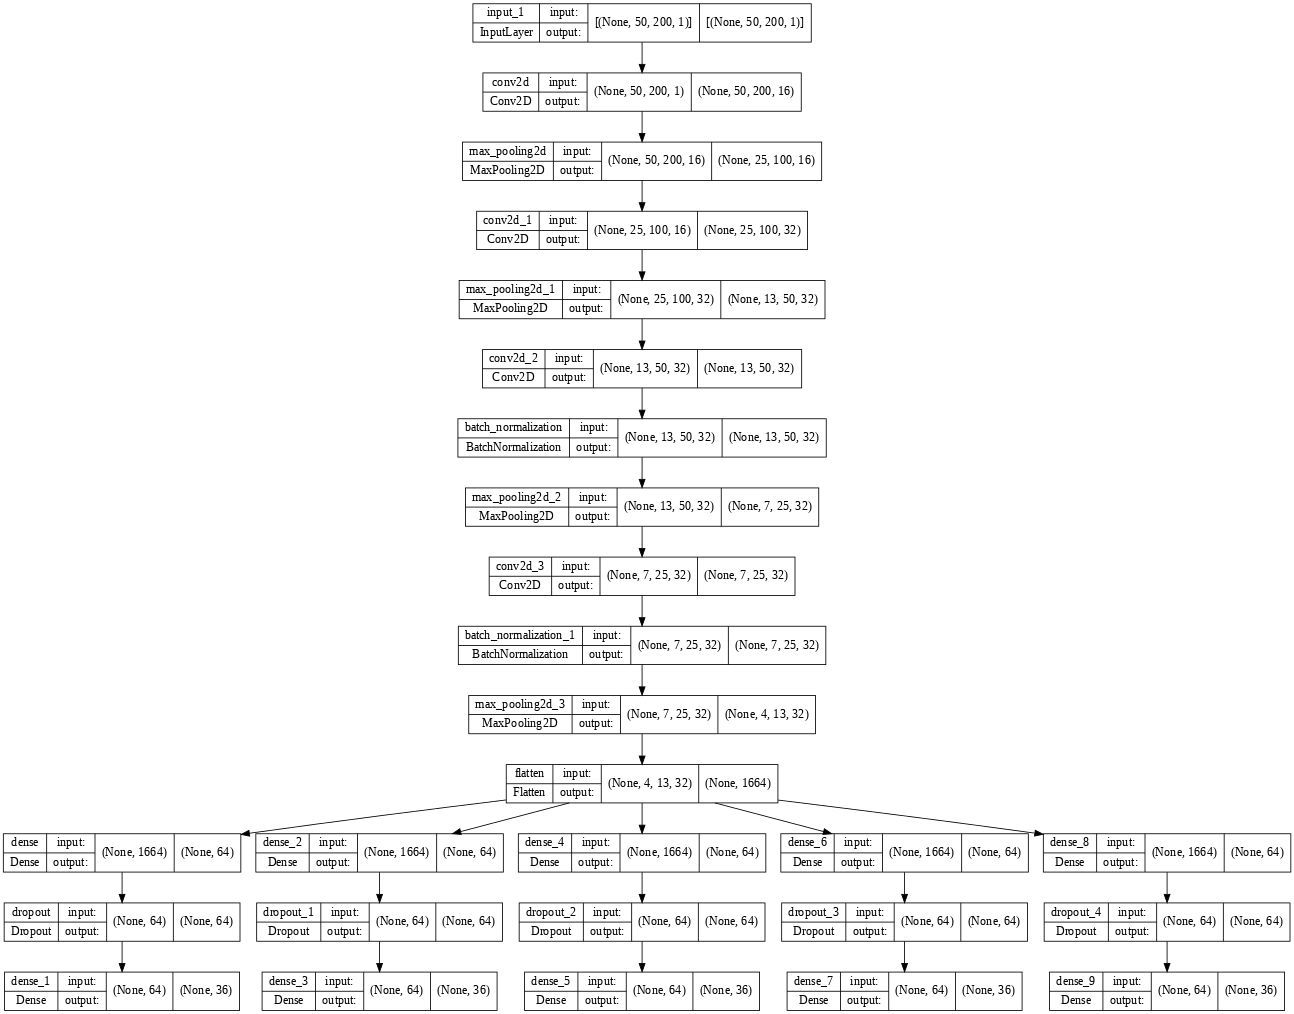

In [12]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

## Train the model

In [ ]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=200,verbose=1, validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/200
25/25 [==============================] - 17s 51ms/step - loss: 2.5568 - dense_1_loss: 0.5418 - dense_3_loss: 0.5296 - dense_5_loss: 0.5527 - dense_7_loss: 0.5178 - dense_9_loss: 0.4150 - dense_1_accuracy: 0.0245 - dense_3_accuracy: 0.0284 - dense_5_accuracy: 0.0438 - dense_7_accuracy: 0.0335 - dense_9_accuracy: 0.0322 - val_loss: 3.0925 - val_dense_1_loss: 0.6350 - val_dense_3_loss: 0.6220 - val_dense_5_loss: 0.6509 - val_dense_7_loss: 0.6185 - val_dense_9_loss: 0.5661 - val_dense_1_accuracy: 0.0464 - val_dense_3_accuracy: 0.0103 - val_dense_5_accuracy: 0.0567 - val_dense_7_accuracy: 0.0206 - val_dense_9_accuracy: 0.0567
Epoch 2/200
25/25 [==============================] - 0s 16ms/step - loss: 1.6028 - dense_1_loss: 0.3448 - dense_3_loss: 0.3367 - dense_5_loss: 0.3746 - dense_7_loss: 0.2985 - dense_9_loss: 0.2483 - dense_1_accuracy: 0.0284 - dense_3_accuracy: 0.0245 - dense_5_accuracy: 0.0361 - dense_7_accuracy: 0.0580 - dense_9_accuracy: 0.0503 - val_loss: 2.8185 - val_den

In [ ]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return  capt #, #sum(probs) / 5 #capt,


In [ ]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

In [ ]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('captcha_v2/train/226md.png'))
print(predict('captcha_v2/samples/f2m8n.png'))
print(predict('captcha_v2/samples/dce8y.png'))
print(predict('captcha_v2/samples/3eny7.png'))
print(predict('captcha_v2/samples/npxb7.png'))


In [ ]:
model_json=model.to_json()
with open("capsecure.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("capsecure.h5")
print("Saved model to disk")

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    plt.figure(figsize=(12,7))
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(figsize=(12,7))
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:

plot_history(hist)

In [ ]:
# print(hist.history.keys())
# summarize history for accuracy
# plt.plot(hist.history['accuracy'])
# plt.plot(hist.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss

# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [ ]:
#testing
c=0
total = 0
for i, pic in enumerate(os.listdir('captcha_v2/train/')):
        #Read image as grayscale
        total += 1
        img = cv2.imread(os.path.join('captcha_v2/train/', pic), cv2.IMREAD_GRAYSCALE)
        #print("Predicted Captcha =",predict(os.path.join('captcha_v2/train/',pic)))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        pr=predict(os.path.join('captcha_v2/train/',pic))
        pic_target = pic[:-4]
        if pr==pic_target:
            c=c+1
            #print(c)
        #print(pic_target)
print("Accuracy = ",(c/total)*100)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#Select a convolutional layer
layer = model.layers[1]

#Get weights
kernels, biases = layer.get_weights()

#Normalize kernels into [0, 1] range for proper visualization
kernels = (kernels - np.min(kernels, axis=3)) / (np.max(kernels, axis=3) - np.min(kernels, axis=3))

#Weights are usually (width, height, channels, num_filters)
#Save weight images
import cv2
plt.figure(figsize=(10,10))
print(kernels.shape[3])
for i in range(kernels.shape[3]):
    filter = kernels[:, :, :, i]
    #cv2.imwrite('filter-{}.png'.format(i), filter)
    plt.subplot(8, 8, i+1)
    plt.imshow((filter * 255).astype(np.uint8))
    plt.axis('off')
plt.show()

In [ ]:
model.layers

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
def predict1(filepath):
    
    img1 = filepath
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
    img = np.reshape(img, (50, 200, 1))  
    img=img/255.0
    res = model.predict(img[np.newaxis,:, :, np.newaxis]) 
    #ans = np.reshape(res, (5, 36))
    '''                                                   #filepath="/content/2b827.png" 
    #img=filepath.reshape(1,50,200,1)
    #img = color.rgb2gray(io.imread(filepath))
    #img=cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) 
    #img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 
    img=filepath
    #if img is not None:
    #    img = img / 255.0
    #else:
    #    print("Not detected");
    #img = np.reshape(img, (50, 200, 1))
    #res = np.array(model.predict(img[np.newaxis,:, :, np.newaxis]))#:, :, np.newaxis [np.newaxis,:, :, np.newaxis]
    res = model.predict(img)[0]
    #ans = np.reshape(res, (5, 36)) 
    '''
    l_ind = []
    probs = []
    for a in res:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]    
    x=(sum(probs)/5)*100 
    x=round(x,3)
    x=str(x)
    capt=capt+ " " +  x + "% Vulnerable"
    return  capt #, sum(probs)/5 #capt,

In [ ]:
from skimage import color
from skimage import io

In [ ]:
image = gr.inputs.Image(shape=(50,200)) #shape=(50,200) 
label = gr.outputs.Label(num_top_classes=1) 
gr.Interface(fn=predict1, inputs="image", outputs="label",interpretation='default',title="CapSecure").launch(debug='True')